In [2]:
import numpy as np
from random import random as rand
from math import floor
from numba import cuda

import matplotlib.pyplot as plt

# Optimization SN P Systems

## Serial version of spiking and guiding

In [13]:
# prob matrix P => chromosome matrix T
# serial version

def spike(P, H, m):
    T = np.zeros((H, m))
    for i in range(H):
        for j in range(m):
            if (rand() < P[i,j]):
                T[i,j] = 1
                
    return T

In [24]:
# chromosome matrix T, prob matrix P, fitness vector F => new prob matrix P
# serial version

def guide(T, P, F, F_argmax, H, m, a, delta):
    for i in range(H):
        for j in range(m):
            if (rand() < a[j]):
                k1, k2 = i, i
                while (k1 == i or k2 == i):
                    k1, k2 = [floor(rand() * H) for i in range(2)]
                b = T[k1,j] if F[k1] > F[k2] else T[k2,j]
                P[i,j] = P[i,j] + delta if b > 0.5 else P[i,j] - delta
            else:
                P[i,j] = P[i,j] + delta if T[F_argmax,j] > 0.5 else P[i,j] - delta
            
            # Adjustments
            if P[i,j] > 1:
                P[i,j] -= delta
            if P[i,j] < 0:
                P[i,j] += delta
    return P

## Parallel versions of spiking and guiding

In [84]:
# prob matrix P => chromosome matrix T
# serial version

@cuda.jit
def parallel_spike(P, Rand, T, H, m):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    grid_size_x = cuda.gridDim.x
    grid_size_y = cuda.gridDim.y

    # For matrices larger than the grid
    x = block_size_x * bx + tx
    y = block_size_y * by + ty

    if (x < P.shape[0] and y < P.shape[1]):
        T[x,y] = 1 if Rand[0,x,y] < P[x,y] else 0

In [85]:
@cuda.jit
def parallel_guide(T, P, F, F_argmax, a, delta, Rand, H, m):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size_x = cuda.blockDim.x
    block_size_y = cuda.blockDim.y
    grid_size_x = cuda.gridDim.x
    grid_size_y = cuda.gridDim.y

    # For matrices larger than the grid
    x = block_size_x * bx + tx
    y = block_size_y * by + ty
    
    # Redefine some things
    H, m = P.shape

    if (x < H and y < m):
        if(Rand[1,x,y] < a[y]):
            k1 = (int)(Rand[2,x,y]*H)
            k2 = (int)(Rand[3,x,y]*H)
            if F[k1] > F[k2]:
                b = T[k1,y]
            else:
                b = T[k2,y]
            P[x,y] = P[x,y] + delta if b > 0.5 else P[x,y] - delta
        else:
            P[x,y] = P[x,y] + delta if T[F_argmax,y] > 0.5 else P[x,y] - delta

        if P[x,y] > 1:
            P[x,y] -= delta
        if P[x,y] < 0:
            P[x,y] += delta

## Serial

In [30]:
def serial_run(H=128, m=128, runs=100, fitness=np.sum):

    def fitness_vector(T):
        F = [fitness(T[i]) for i in range(H)]
        return F

    def fitness_argmax(F):
        arg = 0
        for i in range(1, H):
            arg = i if F[i] > F[arg] else arg
        return arg

    # Define the initial probability array and learning rate
    P = np.random.random_sample((H, m))
    a = 0.15 * np.random.random_sample(m) + 0.05
    delta = 0.015 * rand() + 0.005
    
    # game loop
    # initial fitness

    T = spike(P, H, m)
    F = fitness_vector(T)

    ave_fitness = []
    ave_fitness.append(np.mean(F))

    max_fitness = []
    max_fitness.append(np.max(F))
    
    for r in range(runs):
        guide(T, P, F, fitness_argmax(F), H, m, a, delta)
        T = spike(P, H, m)
        F = fitness_vector(T)
        ave_fitness.append(np.mean(F))
        max_fitness.append(np.max(F))
        
    return ave_fitness, max_fitness

## Parallel

In [31]:
def parallel_run(H=128, m=128, runs=100, threads_per_block=(32,32), blocks_per_grid=(4,4), fitness=np.sum):

    def fitness_vector(T):
        F = [fitness(T[i]) for i in range(H)]
        return F

    def fitness_argmax(F):
        arg = 0
        for i in range(1, H):
            arg = i if F[i] > F[arg] else arg
        return arg

    # Define the initial probability array and learning rate
    P = np.random.random_sample((H, m))
    P_device = cuda.to_device(P)

    a = 0.15 * np.random.random_sample(m) + 0.05
    a_device = cuda.to_device(a)
    delta = 0.015 * rand() + 0.005
    
    # game loop
    # initial fitness

    T = np.zeros((H,m))
    T_device = cuda.to_device(T)
    Rand = np.random.random_sample((1, H, m))
    Rand_device = cuda.to_device(Rand)

    parallel_spike[blocks_per_grid, threads_per_block](P_device,Rand_device,T_device,H,m)
    F = fitness_vector(T_device.copy_to_host())

    ave_fitness = []
    ave_fitness.append(np.mean(F))

    max_fitness = []
    max_fitness.append(np.max(F))
    
    for r in range(runs):
        Rand = np.random.random_sample((4, H, m))
        Rand_device = cuda.to_device(Rand)

        F_argmax = fitness_argmax(F)
        F_device = cuda.to_device(F)
        parallel_guide[blocks_per_grid, threads_per_block](T_device,P_device,F_device,F_argmax,a_device,delta,Rand_device,H,m)
        parallel_spike[blocks_per_grid, threads_per_block](P_device,Rand_device,T_device,H,m)

        F = fitness_vector(T_device.copy_to_host())
        ave_fitness.append(np.mean(F))
        max_fitness.append(np.max(F))
        
    return ave_fitness, max_fitness

## Fitness Function

In [33]:
def return_ffunc(m):
    omega = m*3
    K = m
    w = np.random.randint(1, omega, K)
    p = w + 0.5*omega
    C = 0.5*np.sum(w)

    def f_knapsack(arr):
        knapsack = np.sum(np.multiply(arr, p))
        load = np.sum(np.multiply(arr, w))
        return knapsack if load <= C else -1
    
    return f_knapsack

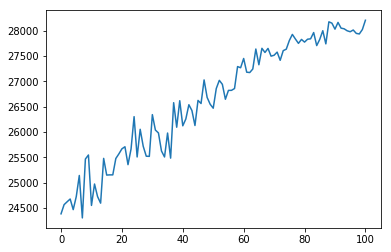

In [38]:
plt.plot(np.arange(101), max_f)

## Testing for multiple cases

### Number of runs

In [39]:
threads_per_block = (32,32)
blocks_per_grid = (4,4)
H = 128
m = 128
ff = return_ffunc(m)

In [81]:
runs = 750

In [82]:
%time ave_f, max_f = serial_run(H=H, m=m, runs=runs, fitness=ff)

Wall time: 31.4 s


In [83]:
%timeit ave_p, max_p = parallel_run(H=H, m=m, runs=runs, fitness=ff)

2.61 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
# For recording

runs = [
    100,
    250,
    500,
    750,
    1000,
]

serial_runs = [
    3.900,
    10.200,
    21.100,
    31.400,
    43.400,
]

parallel_runs = [
    .336,
    .841,
    1.650,
    2.610,
    3.430,
]

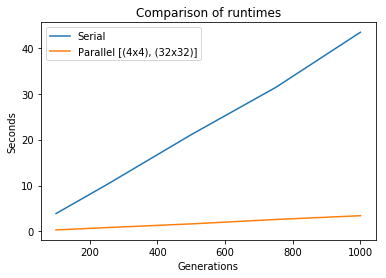

In [90]:
plt.plot(runs, serial_runs)
plt.plot(runs, parallel_runs)

plt.legend(['Serial', 'Parallel [(4x4), (32x32)]'], loc='upper left')

plt.xlabel('Generations')
plt.ylabel('Seconds')
plt.title('Comparison of runtimes')

plt.show()

In [91]:
ave_f, max_f = serial_run(H=H, m=m, runs=1000, fitness=ff)

In [95]:
ave_p, max_p = parallel_run(H=H, m=m, runs=1000, fitness=ff)

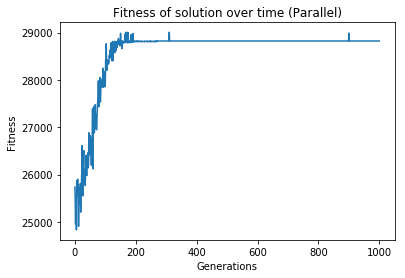

In [96]:
plt.plot(np.arange(1001), max_p)

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness of solution over time (Parallel)')

plt.show()

## System size

In [122]:
threads_per_block = (16,64)
blocks_per_grid = (16,16)
H = 64
m = 1024
runs = 1000
ff = return_ffunc(m)

In [113]:
%timeit ave_p, max_p = parallel_run(H=H, m=m, runs=runs, threads_per_block=threads_per_block, blocks_per_grid=blocks_per_grid, fitness=ff)

6.83 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%time ave_f, max_f = serial_run(H=H, m=m, runs=runs, fitness=ff)

Wall time: 2min 48s


In [117]:
# 64 items

items = [
    "128",
    "256",
    "512",
    "1024",
]

serial_runs = [
    21.9,
    42.6,
    82,
    168,
]

parallel_runs = [
    2.37,
    2.91,
    4.5,
    6.83,
]

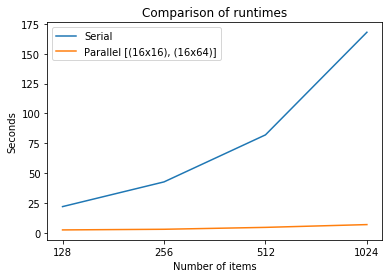

In [121]:
plt.plot(items, serial_runs)
plt.plot(items, parallel_runs)

plt.legend(['Serial', 'Parallel [(16x16), (16x64)]'], loc='upper left')

plt.xlabel('Number of items')
plt.ylabel('Seconds')
plt.title('Comparison of runtimes')

plt.show()

In [125]:
ave_p, max_p2 = parallel_run(H=H, m=m, runs=runs, threads_per_block=threads_per_block, blocks_per_grid=blocks_per_grid, fitness=ff)
ave_f, max_f2 = serial_run(H=H, m=m, runs=runs, fitness=ff)

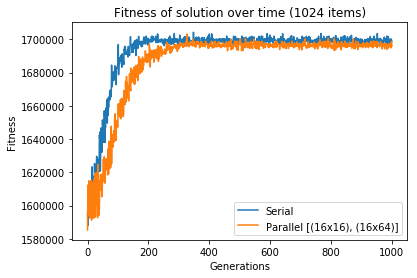

In [126]:
plt.plot(np.arange(1001), max_f2)
plt.plot(np.arange(1001), max_p2)

plt.legend(['Serial', 'Parallel [(16x16), (16x64)]'], loc='lower right')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness of solution over time (1024 items)')

plt.show()